- 나눔글꼴 설치 및 적용
    - 설치 후 런타임 재시작 필요

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetyp

- 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- 서드파티 모듈 설치

In [ ]:
!pip install konlpy
!pip install mecab-python
!apt-get install -y openjdk-8-jdk
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-8-jdk is already the newest version (8u392-ga-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1022k      0  0:00:01  0:00:01 --:--:-- 1022k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1
mecab-0.996-ko-0.9.2/man/Makefile.in

# [1] 모듈 로드

In [ ]:
# os
import os
import sys
import re
import warnings
import random

# 분석
import pandas as pd
import numpy as np


# 시각화
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ML
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import LabelEncoder, MinMaxScaler



# Text
from konlpy.tag import Mecab
from konlpy.tag import Kkma
from konlpy.utils import pprint
from sklearn.feature_extraction.text import TfidfVectorizer


warnings.filterwarnings('ignore')
%matplotlib inline

- 시드 고정

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(22) # Seed 고정

# [2] 데이터 로드

- bank_info_df : 은행 등급 계산
- dp_df : 은행/저축은행 적금상품 전체

In [ ]:
bank_info_df = pd.read_csv("/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/경영지표/bank_grade.csv",encoding = 'cp949')

is_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_all.csv', encoding = 'utf-8')
is6_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_6.csv', encoding = 'utf-8')
is12_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_12.csv', encoding = 'utf-8')
is24_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_24.csv', encoding = 'utf-8')
is36_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_36.csv', encoding = 'utf-8')

In [ ]:
is6_df.shape, is12_df.shape, is24_df.shape, is36_df.shape

((251, 17), (388, 17), (334, 17), (301, 17))

In [ ]:
# 데이터 선택
df_tmp = is6_df

In [ ]:
# 등급 추가
df_tmp = pd.merge(left = df_tmp, right = bank_info_df[['구분','등급']], how = 'left',
         left_on = '금융회사' , right_on = "구분")

In [ ]:
df_tmp.head(2)

,금융회사,상품명,적립방식,세전이자율,세후이자율,세후이자(예시),최고우대금리,가입대상,이자계산방식,기간,비교 공시일,담당부서 및 연락처,우대조건,가입대상.1,가입방법,만기후 이자율,기타유의사항,구분,등급
0,경남은행,BNK 위더스(With-us)자유적금,정액적립식,-,-,-,6.25%,제한없음,단리,6개월,2023-10-23,"리테일금융부(대출문의),055-290-8743 마케팅추진부(예·적금상품),1600-...",①ESG 실천 우대금리 1.50% - 영업점 가입 및 증빙서류 지참 한하여 적용 (...,개인 및 개인사업자,"영업점,인터넷",만기후 1개월 이내: 일반정기예금 기본이율의 50%\n만기후 1개월 초과: 일반정기...,1.계약기간은 1개월 이상 36개월 이내 월단위\n2.1인 1계좌\n3.매월 최소 ...,경남은행,2.0
1,페퍼저축은행,AI Peppers 배구사랑 정기적금,정액적립식,6.00%,5.08%,"8,883",6.00%,제한없음,단리,6개월,2023-01-16,예금담당자 03180159344 대출문의 15990722,우대사항 없음,개인고객(당행 입출금 계좌 보유 고객 중 페퍼스타디움 방문 관람 시 제공된 쿠폰코드...,스마트폰,*신규가입일 당시 영업점 및 인터넷 홈페이지에 고시한 경과기간별 만기후이자율 적용\...,*최소가입금액: 1만원 이상\n*최고한도(단위:원) 50만원(정액 적립식),페퍼저축은행,5.0


# [3] 문자열 전처리

### 3.1 불필요 칼럼 삭제

In [ ]:
df_tmp = df_tmp.drop(['기간','비교 공시일','담당부서 및 연락처','세후이자(예시)'], axis = 1)

###3.2 가입 대상 칼럼 전처리

In [ ]:
# 가입대상 칼럼보다 가입대상.1 칼럼이 더 자세한 정보 제공
# 가입대상 컬럼은 "제한없음"과 "일부제한" 밖에 존재하지 않음 (6개월기준)

df_tmp['가입대상_최종'] = df_tmp['가입대상.1']

# '가입대상'과 '가입대상.1' 칼럼 삭제 (통합)
df_tmp.drop(['가입대상', '가입대상.1'], axis=1, inplace=True)

# 비어있는 값 '제한없음'으로 채운다.
df_tmp['가입대상_최종'].fillna('제한없음', inplace=True)

- 가입대상 추가 전처리
     - 가입대상 조건을 추출하되, 없음/제한없음 등 실질적으로 가입대상 제한조건이 없는 경우는 모두 "제한없음"으로 통일해줌

In [ ]:
word_list = ["없음","제한없음","누구나가입","모든고객", '실명의개인', "개인", "누구나가입가능", '누구나 가입가능']
target_list = []
for i in range(len(df_tmp)):
    text = str(df_tmp.loc[i,'가입대상_최종'])
    text = re.sub('[^0-9a-zA-Zㄱ-ㅎ가-힣]', "", text)
    text = text.replace(" ","")
    Flag = False
    for w in word_list:
        if w == text:
            Flag = True
            break
    if Flag == True :
        target_list.append('제한없음')
    else:
        target_list.append(df_tmp.loc[i,'가입대상_최종'])


In [ ]:
df_tmp['가입대상_최종'] = target_list
df_tmp['가입대상_최종'].unique()

array(['개인 및 개인사업자',
       '개인고객(당행 입출금 계좌 보유 고객 중 페퍼스타디움 방문 관람 시 제공된 쿠폰코드를 수령한 고객, 1인1계좌),\n쿠폰 유효기간에 한함',
       '개인 고객 - 당행 입출금계좌 보유 고객 - PAYCO 앱에서 진행하는 이벤트 참여 후 쿠폰코드를 수령한 고객(1인 1계좌) 단, 쿠폰 유효기간에 한함',
       '제한없음', '인터넷 및 모바일뱅킹 사용자', '19~39세',
       '만19세이상 내국인 개인고객, 본인 스마트폰 소지자, 신분증(주민등록증 또는 운전면허증)소지자, 최근 30일이내 전은행에서 입출금통장 개설내역이 없는 고객, 미국인 납세자에 해당하지 않는 고객',
       '만 17세 이상의 실명의 개인', '실명의 개인\n(개인사업자 제외)',
       '만19세이상 내국인 개인고객, 본인 스마트폰 소지자, 신분증(주민등록증 또는 운전면허증)소지자, 최근 30일이내 전은행에서 입출금통장 개설내역이 없는 고객, 미국인납세자에 해당하지 않는 고객',
       '만 17세 이상 실명의 개인 및 개인사업자', '만19세 이상 내국인(법인불가)', '실명의 개인 및 개인사업자',
       '거래대상자는 제한을 두지 아니한다. 다만, 국가 및 지방자치단체는 이 예금을 거래할 수 없다.',
       '비대면 어플사용자', '실명의 개인\n또는 개인사업자(1인 다계좌 가능)', '개인(개인사업자 포함)',
       '제한없음(단,국가및지방자치단체제외)', '실명의 개인고객(1인 1계좌)', '만19세이상 개인(내국인만 가능)',
       '만19세~만34세 개인 및 개인사업자', '-만19세이상의 개인', '인터넷뱅킹가입 대상', '만17세이상',
       '인터넷뱅킹, 스마트폰뱅킹 전용', '미취학아동과 부모님이 함께 가입', '개인 및 법인고객',
       '만 19세 이상 실명의 개인고객 (1인 1계좌)', '내·외국인 대상', '내국인 대상',
    

In [ ]:
# 수치형으로 군집분석에 이용하기 위한 라벨링
## 0 : 가입대상이 따로 존재하지 않음
## 1 : 가입대상이 따로 존재함

def label_based_on_target(row):
    if row['가입대상_최종'] == '제한없음':
        return 0
    else:
        return 1

df_tmp['가입대상_존재여부_en'] = df_tmp.apply(label_based_on_target, axis=1)

- 가입대상 존재 여부 확인
    - 적금 6개월의 경우 가입대상이 별도로 존재하는 경우는 약 22.71% 정도이다.

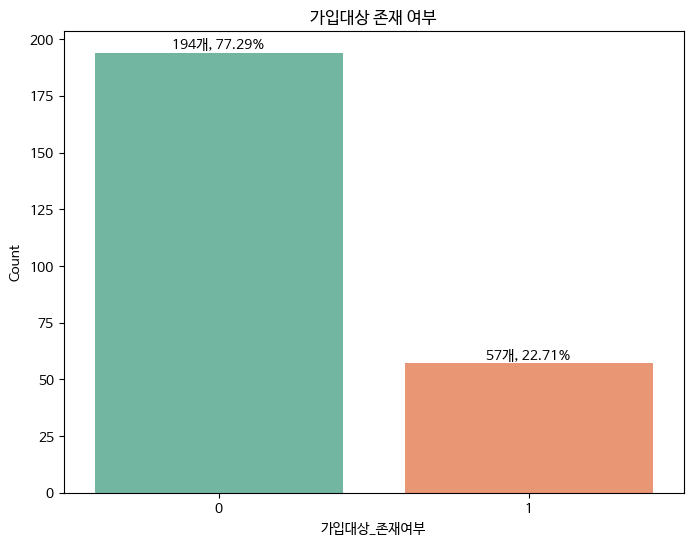

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='가입대상_존재여부_en', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개, {round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.title('가입대상 존재 여부')
plt.xlabel('가입대상_존재여부')
plt.ylabel('Count')
plt.show()


- 가입대상에서 나이 추출
    - 가입대상 조건에서 나이관련 조건이 있을 경우 추출한다.

In [ ]:
range_list = ['미만','이하','이상','초과']
p =re.compile('[0-9]+세')
p2 = re.compile('[0-9]+~[0-9]+세')
p3 = re.compile('[0-9]+~[0-9]+대')

In [ ]:
age_list = []
for i in range(len(df_tmp)):
    text_ori = df_tmp.loc[i,'가입대상_최종']
    text = text_ori.replace(" ","")

    if p3.search(text):
        s = p3.search(text).span()
        age_list.append(text[s[0]:s[1]])
    elif p2.search(text):
        s = p2.search(text).span()
        age_list.append(text[s[0]:s[1]])
    elif p.search(text):
        s = p.search(text).span()
        for r in range_list:
            range_w = ""
            if text[s[1]:s[1]+2] == r:
                range_w = text[s[1]:s[1]+2]
                break
        age_list.append(text[s[0]:s[1]] +" " +  range_w)
    else:
        age_list.append("나이제한없음")
print(age_list)

['나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '19~39세', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '19세 이상', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '17세 이상', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '19세 이상', '나이제한없음', '17세 이상', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '17세 이상', '19세 이상', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '19세 이상', '19세 ', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '19세 이상', '나이제한없음', '나이제한없음', '17세 이상', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '

In [ ]:
df_tmp['나이제한'] = age_list

In [ ]:
# 수치형으로 군집분석에 이용하기 위한 라벨링
## 0 : 나이제한이 존재하지 않음
## 1 : 나이제한이 존재함


def label_based_on_target(row):
    if row['나이제한'] == '나이제한없음':
        return 0
    else:
        return 1

df_tmp['나이제한_존재여부_en'] = df_tmp.apply(label_based_on_target, axis=1)

- 나이 제한 존재여부 확인
    - 적금 6개월의 경우 6.37% 정도 나이제한이 존재한다.

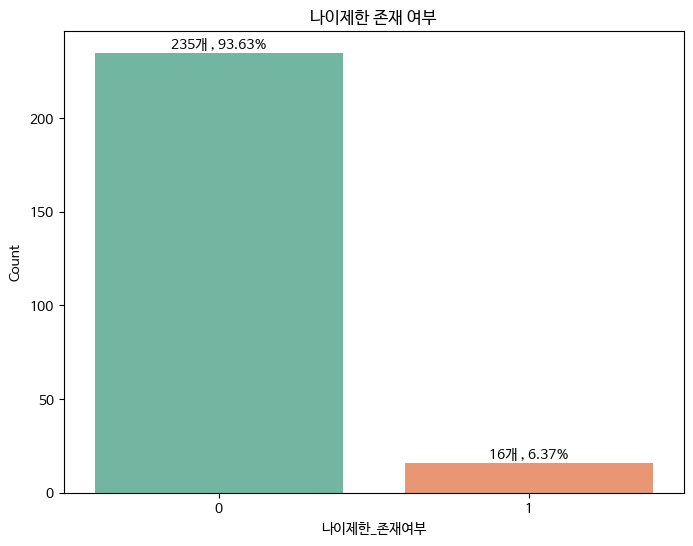

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='나이제한_존재여부_en', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개 , {round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('나이제한 존재 여부')
plt.xlabel('나이제한_존재여부')
plt.ylabel('Count')
plt.show()

### 3.3 우대조건 전처리

- 우대조건 칼럼 전처리
    - 없음이 다양한 형태로 입력되어 있음
    - 우대조건이 없을 경우 모두 '없음'으로 통일해 우대조건 존재여부를 확인한다.

In [ ]:
no_prime = ['없음', '해당없음', '','해당사항없음',  '우대조건없음', '우대사항없음' ,  '해당무']

def clean_text(inputString):
  text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', '', inputString)
  return text_rmv

df_tmp['우대조건'] = df_tmp['우대조건'].apply(lambda x: '없음' if clean_text(x).replace(" ","")in no_prime else x)

In [ ]:
# 수치형으로 군집분석에 이용하기 위한 라벨링
## 0 : 우대조건이 존재하지 않음
## 1 : 우대조건이 존재함

def label_based_on_target(row):
    if row['우대조건'] == '없음':
        return 0
    else:
        return 1

df_tmp['우대조건_존재여부_en'] = df_tmp.apply(label_based_on_target, axis=1)

- 우대조건 존재 여부 확인
    - 적금 6개월의 경우 우대조건이 존재하는 상품은 30% 정도이다.

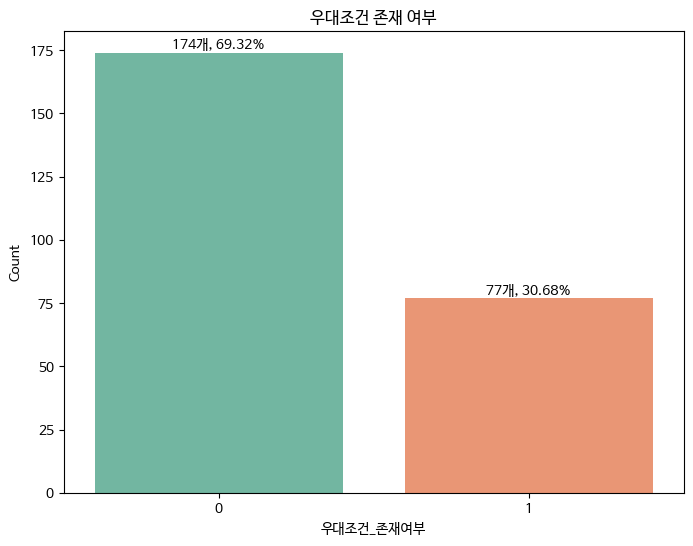

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='우대조건_존재여부_en', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개, {round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('우대조건 존재 여부')
plt.xlabel('우대조건_존재여부')
plt.ylabel('Count')
plt.show()

- 가입방식에 따른 우대조건 존재여부

In [ ]:
def create_method(x):
    method_list_e = ['인터넷','모바일','스마트','비대면']
    for m in method_list_e :
        if m in x :
            return '비대면'
    method_list = ['창구','영업점']
    for m in method_list:
        if m in x :
            return "대면"
    return "우대없음"

In [ ]:
df_tmp['가입방식우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :create_method(x) )

In [ ]:
df_tmp['가입방식우대_존재여부'].value_counts()

우대없음    220
비대면      24
대면        7
Name: 가입방식우대_존재여부, dtype: int64

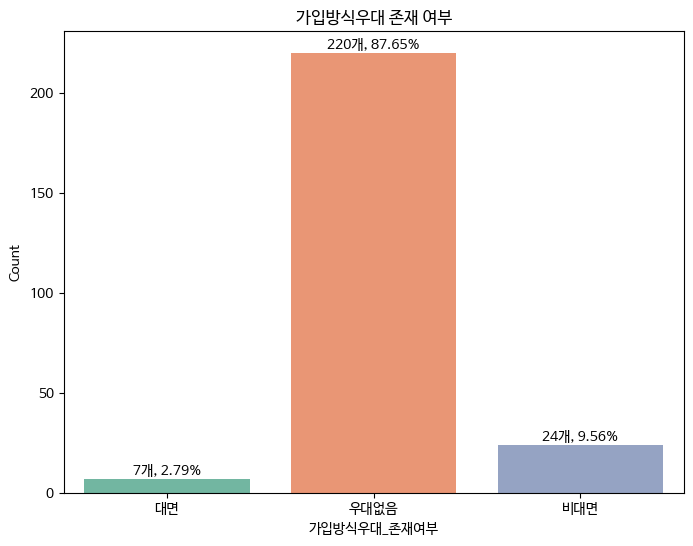

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='가입방식우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개, {round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('가입방식우대 존재 여부')
plt.xlabel('가입방식우대_존재여부')
plt.ylabel('Count')
plt.show()

- 자동이체에 따른 우대사항 존재여부

In [ ]:
# 이체 우대
def transfer(x):
    if "이체" not in x:
        return "우대없음"
    if "자동" in x:
        return "자동이체우대"
    if "급여" in x  or "소득" in x :
        return "급여이체우대"

In [ ]:
df_tmp['이체우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :transfer(x) )

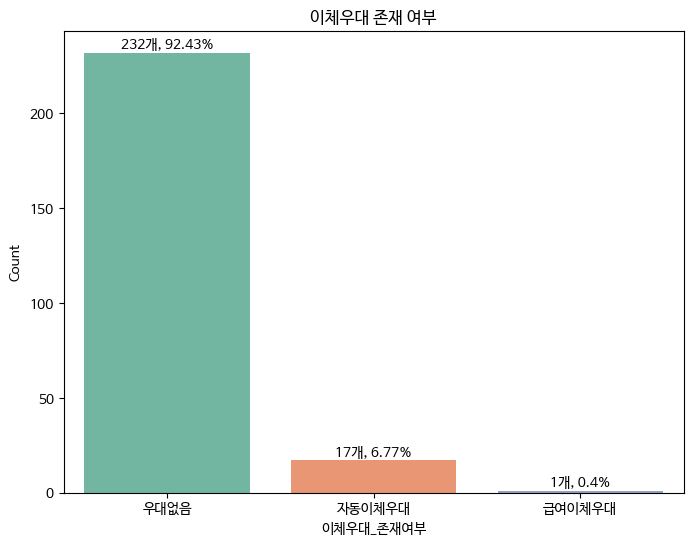

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='이체우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개, {round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('이체우대 존재 여부')
plt.xlabel('이체우대_존재여부')
plt.ylabel('Count')
plt.show()

- 만기 이후 우대사항 존재 여부

In [ ]:
# 만기 우대
def maturity(x):
    if "만기" not in x:
        return "우대없음"
    if "만기" in x:
        return "만기시우대"

In [ ]:
df_tmp['만기우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :maturity(x) )

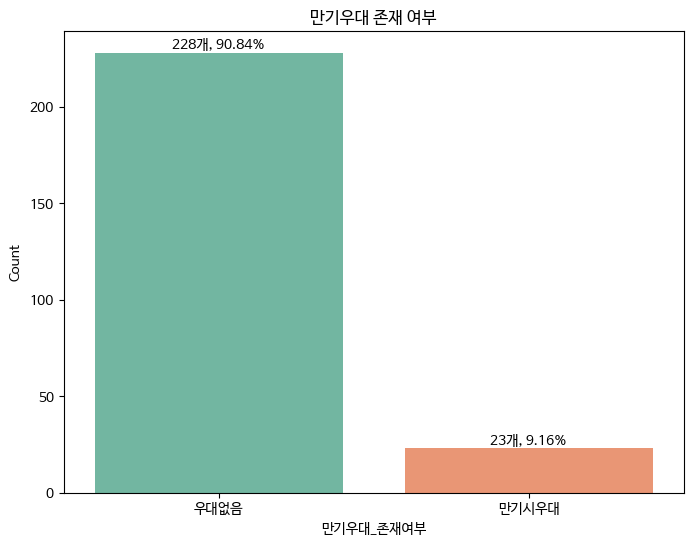

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='만기우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개, {round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('만기우대 존재 여부')
plt.xlabel('만기우대_존재여부')
plt.ylabel('Count')
plt.show()

- 실적에 따른 우대사항 존재 여부

In [ ]:
# 실적 우대
def card(x):
    if "실적" not in x and "카드" not in x:
        return "우대없음"
    if "카드" in x:
        return "카드실적우대"
    if "실적" in x:
        return "카드 외 실적우대"

df_tmp['실적우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :card(x) )

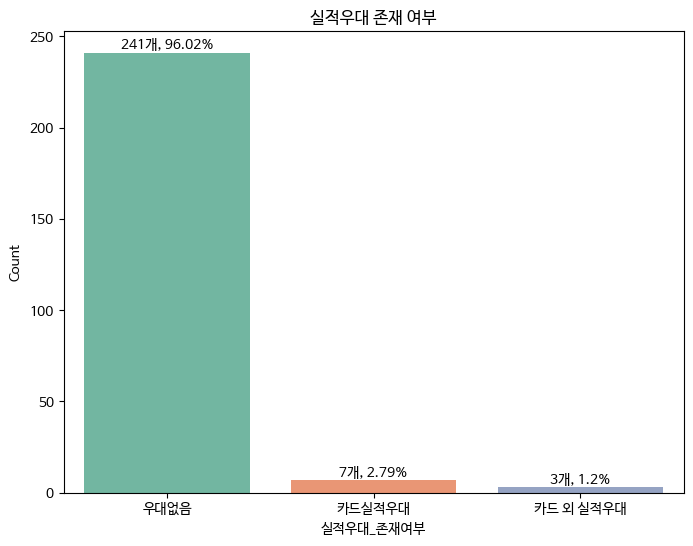

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='실적우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개, {round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('실적우대 존재 여부')
plt.xlabel('실적우대_존재여부')
plt.ylabel('Count')
plt.show()

- 기타우대

    - 마케팅 동의
    - 청약
    - 신규
    - 직장인

In [ ]:
def etc(x):
    list_ = []
    if "동의" in x:
        list_.append("마켓팅동의우대")
    if "청약" in x:
        list_.append("청약가입우대")
    if ("신규" in x )or ("첫거래" in x) or ("최초" in x )or( "첫번째" in x):
        list_.append("최초고객우대")
    if "직장인" in x or "근로자" in x :
        list_.append("직장인우대")
    if "당행" in x or "당사" in x:
        list_.append("해당은행우대")
    if not list_:
        return "우대없음"
    else:
        return " ".join(list_)

In [ ]:
df_tmp['기타우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :etc(x) )

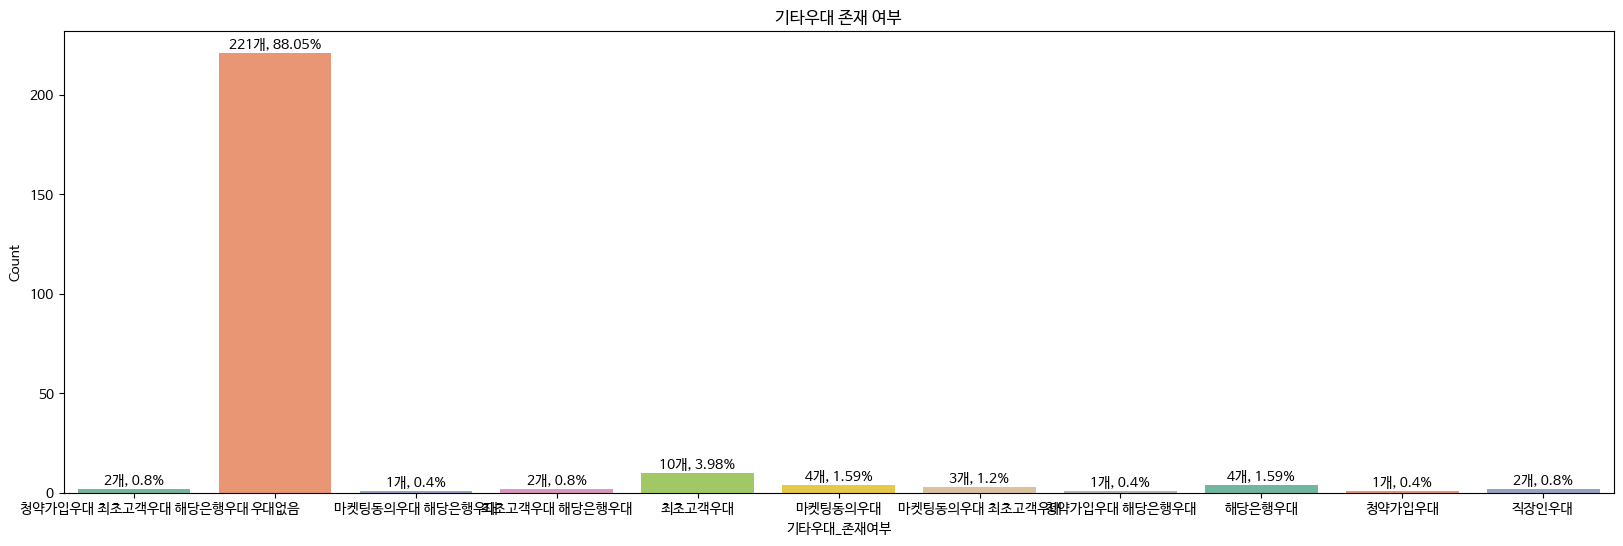

In [ ]:
plt.figure(figsize=(20, 6))
ax = sns.countplot(x='기타우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개, {round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('기타우대 존재 여부')
plt.xlabel('기타우대_존재여부')
plt.ylabel('Count')
plt.show()

### 3.4 % to float

- %문자열 수치형으로 변환

In [ ]:
df_tmp['세전이자율'] = df_tmp['세전이자율'].apply(lambda x : np.nan if "%" not in x else x)
df_tmp['세전이자율'] = df_tmp['세전이자율'].str.rstrip('%').astype('float')
df_tmp['세후이자율'] = df_tmp['세후이자율'].apply(lambda x : np.nan if "%" not in x else x)
df_tmp['세후이자율'] = df_tmp['세후이자율'].str.rstrip('%').astype('float')
df_tmp['최고우대금리'] = df_tmp['최고우대금리'].apply(lambda x : np.nan if "%" not in x else x)
df_tmp['최고우대금리'] = df_tmp['최고우대금리'].str.rstrip('%').astype('float')

### 3.5 실질 이자율 추가
- 실질 이자율 : 만기 후 받게되는 이자의 현시점 기준 가치 산출
- 참고 : https://github.com/todhm/finda
- 23년 11월 기준 한국은행 기준금리는 3.5%로 실질이자율이 0 미만인 상품들이 다수 존재한다.

In [ ]:
bir = 0.035 # 현재 기준금리 3.5% 반영

def month_real(interest,month):
    if not np.isnan(interest):
        a =  - sum([ -100 / (1.0125) ** (i/12.0)   for i in range(0,month)]) #만기시까지 지급한 금액의 현재가치
        b = 100.0 * month + np.sum([ 100 * (interest * 0.01) * i / 12.0   for i in range(1,month + 1)]) #만기후 수령액의 미래가치
        b = b / (1.0125)**(month/12.0) # 만기후 수령액의 현재가치

        return ((b/a)**(12.0/month) - 1) * 100
    else:
        return 0
def month_complex_real(interest,month):
    if interest != np.nan:
        a =  - sum([ -100 / (1.0125) ** (i/12.0)   for i in range(0,month)])
        b = np.sum([ 100 *   (1+ ((interest * 0.01) / 12.0)) ** (i)  for i in range(1,month + 1)])
        b = b / (1.0125)**(month/12.0)
        return ((b/a)**(12.0/month) - 1) * 100
    else:
        return 0

In [ ]:
real_interest = []
interest_period = []

for i in range(len(df_tmp)):
    if df_tmp.loc[i, '이자계산방식'] == '단리':  # 상품의 금리방식이 단리인 경우
        real_interest.append(month_real(df_tmp.loc[i, '세전이자율'], 6))
        interest_period.append(6)

    elif df_tmp.loc[i, '이자계산방식'] == '복리':  # 상품의 금리방식이 복리인 경우
        real_interest.append(month_complex_real(df_tmp.loc[i, '세전이자율'], 6))
        interest_period.append(6)

print(real_interest)

[0, 2.7827838772566116, 2.194374137588606, 1.8128135862016448, 1.8128135862016448, 1.8128135862016448, 1.8128135862016448, 1.8128135862016448, 1.7834923337909148, 1.7834923337909148, 1.7834923337909148, 1.7834923337909148, 1.7834923337909148, 1.7541753041279362, 1.7541753041279362, 1.666249551625687, 1.6076534970297596, 1.6076534970297596, 1.6076534970297596, 1.6076534970297596, 1.6076534970297596, 1.6076534970297596, 1.5490743334248824, 1.5490743334248824, 1.5490743334248824, 1.4905120608110334, 1.4319666791883456, 1.4319666791883456, 1.4319666791883456, 1.4319666791883456, 1.4027003224986512, 1.373438188556686, 1.384003729725225, 1.373438188556686, 1.384003729725225, 1.373438188556686, 1.373438188556686, 1.373438188556686, 1.373438188556686, 1.314926588916232, 1.314926588916232, 1.314926588916232, 1.314926588916232, 1.3249095788311571, 1.314926588916232, 1.314926588916232, 1.314926588916232, 1.314926588916232, 1.314926588916232, 1.314926588916232, 1.314926588916232, 1.314926588916232

In [ ]:
df_tmp['실질이자율'] = real_interest

### 3.6 가입방법 칼럼 전처리
- 전처리 방식
    - '인터넷,스마트폰', -> 인터넷스마트폰전용
    - '영업점', -> 영업점방문
    - '스마트폰', -> 인터넷스마트폰전용
    - '인터넷', -> 인터넷스마트폰전용
    - '영업점,인터넷', -> 인터넷스마트폰영업점
    - '인터넷,스마트폰,전화(텔레뱅킹)', -> 인터넷스마트폰텔레뱅킹
    - '영업점,인터넷,스마트폰', -> 인터넷스마트폰영업점
    - '영업점,스마트폰', -> 인터넷스마트폰영업점
    - '영업점,인터넷,스마트폰,전화(텔레뱅킹)' -> 인터넷스마트폰텔레뱅킹



In [ ]:
# join_method_mapping = {
#     '인터넷,스마트폰': '인터넷스마트폰전용',
#     '영업점': '영업점방문',
#     '스마트폰': '인터넷스마트폰전용',
#     '스마트폰,전화(텔레뱅킹)' : '인터넷스마트폰텔레뱅킹',
#     '인터넷': '인터넷스마트폰전용',
#     '영업점,인터넷': '인터넷스마트폰영업점',
#     '인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰텔레뱅킹',
#     '영업점,인터넷,스마트폰': '인터넷스마트폰영업점',
#     '영업점,스마트폰': '인터넷스마트폰영업점',
#     '영업점,인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰영업점텔레뱅킹',
#     '없음' : '기타',
#     '모집인' : '기타'
# }

# # 딕셔너리에 따라 값들 변경
# df_tmp['가입방법'] = df_tmp['가입방법'].map(join_method_mapping)

# print(df_tmp['가입방법'].value_counts())

- 텔레뱅킹이 포함된 상품은 많지 않으며, 현재 사용하지 않는 추세이다. 따라서 해당 부분은 이상치로 규정하고 대체한다.

In [ ]:
join_method_mapping = {
    '인터넷,스마트폰': '인터넷스마트폰전용',
    '영업점': '영업점방문',
    '스마트폰': '인터넷스마트폰전용',
    '스마트폰,전화(텔레뱅킹)' : '인터넷스마트폰전용',
    '인터넷': '인터넷스마트폰전용',
    '영업점,인터넷': '인터넷스마트폰영업점',
    '인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰전용',
    '영업점,인터넷,스마트폰': '인터넷스마트폰영업점',
    '영업점,스마트폰': '인터넷스마트폰영업점',
    '영업점,인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰영업점',
    '없음' : '기타',
    '모집인' : '기타'
}

# 딕셔너리에 따라 값들 변경
df_tmp['가입방법'] = df_tmp['가입방법'].map(join_method_mapping)

print(df_tmp['가입방법'].value_counts())

인터넷스마트폰전용     133
영업점방문          68
인터넷스마트폰영업점     48
기타              1
Name: 가입방법, dtype: int64


# [4] 수치형 전처리

- 최고_기본_diff :  최고우대금리 - 세전이자율
- 6개월 기준 : 0이 아닌것 - 42개

In [ ]:
df_tmp['최고_기본_diff'] = df_tmp['최고우대금리'] - df_tmp['세전이자율']

In [ ]:
df_tmp['최고_기본_diff'].unique()

array([ nan, 0.  , 1.  , 0.1 , 0.2 , 1.5 , 0.6 , 2.25, 0.7 , 0.5 , 2.1 ,
       1.2 , 0.55, 0.8 , 0.4 , 3.5 , 1.7 , 3.  , 0.35, 0.9 , 0.45, 0.1 ,
       2.7 , 4.  , 2.  , 2.5 , 0.1 ])

In [ ]:
# 수치형으로 군집분석에 이용하기 위한 라벨링
## 0 : 값이 차이나지 않음 혹은 nan 값
## 1 : 0.5 이하로 값이 차이나는 값
## 2 : 우대금리와 기본금리의 차이가 0.5% 초과


def label_based_on_target(row):
    if row['최고_기본_diff'] == 0 or np.isnan(row['최고_기본_diff']):
        return 0
    elif row['최고_기본_diff'] <= 0.5:
        return 1
    else:
        return 2

df_tmp['최고기본금리차이'] = df_tmp.apply(label_based_on_target, axis=1)

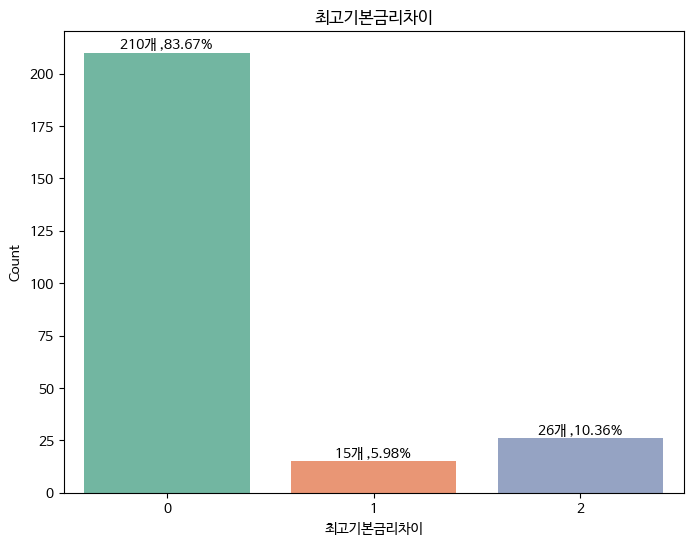

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='최고기본금리차이', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개 ,{round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('최고기본금리차이')
plt.xlabel('최고기본금리차이')
plt.ylabel('Count')
plt.show()

- 최고_기준_diff : 최고우대금리 - 현재금리(3.5)

In [ ]:
df_tmp['최고_기준_diff'] = df_tmp['최고우대금리'] - 3.5

In [ ]:
# 수치형으로 군집분석에 이용하기 위한 라벨링
## 0 : 마이너스값
## 1 : 0.25 이하로 값이 차이나는 값
## 2 : 차이가 0.5% 이하
## 3 : 그 이상 차이


def label_based_on_target(row):
    if row['최고_기준_diff'] < 0 :
        return 0
    elif row['최고_기준_diff'] <= 0.25:
        return 1
    elif row['최고_기준_diff'] <= 0.5:
        return 2
    else:
        return 3

df_tmp['최고기준금리차이'] = df_tmp.apply(label_based_on_target, axis=1)

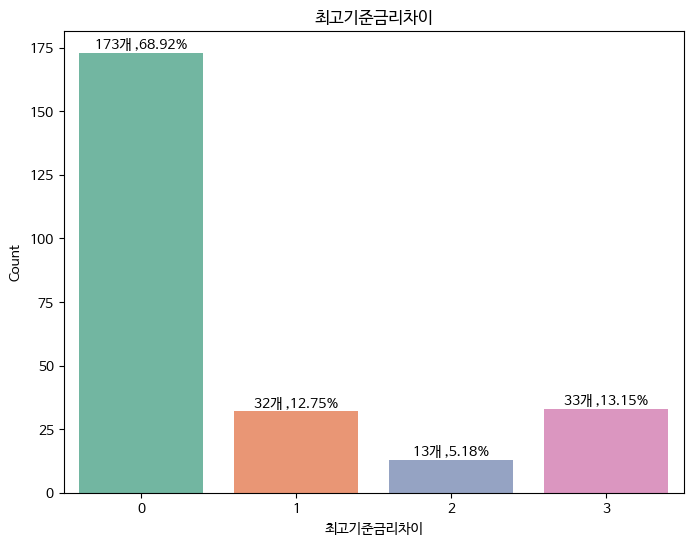

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='최고기준금리차이', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개 ,{round(p.get_height() * 100/len(df_tmp), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('최고기준금리차이')
plt.xlabel('최고기준금리차이')
plt.ylabel('Count')
plt.show()

- 은행 구분

In [ ]:
bank_list = list(set(list(df_tmp['금융회사'].unique())))

# 저축은행(jb)와 일반은행(gb)로 분할한다.
jb = []
gb = []
ob = ['주식회사 카카오뱅크',  '토스뱅크 주식회사', '주식회사 케이뱅크']

for bank in bank_list:
    if '저축' in bank:
        jb.append(bank)
    else:
        gb.append(bank)

gb_not_ob = [bank for bank in gb if bank not in ob]

# 결과 출력
print("저축은행 리스트:", jb)
print("일반은행 리스트:", gb)
print("온라인은행 리스트:", ob)
print("온라인은행 제외 일반은행:", gb_not_ob)

저축은행 리스트: ['하나저축은행', '흥국저축은행', '디비저축은행', '대백저축은행', '우리저축은행', '키움저축은행', '진주저축은행', '대아상호저축은행', '한화저축은행', '더케이저축은행', '세람저축은행', 'BNK저축은행', '바로저축은행', 'JT저축은행', '드림저축은행', '안양저축은행', '참저축은행', '스타저축은행', '동원제일저축은행', '동양저축은행', '청주저축은행', '융창저축은행', '예가람저축은행', '조흥저축은행', '라온저축은행', '상상인저축은행', '스카이저축은행', 'MS저축은행', '대한저축은행', '삼호저축은행', '신한저축은행', 'OSB저축은행', '영진저축은행', '우리금융저축은행', '키움예스저축은행', '솔브레인저축은행', 'IBK저축은행', 'JT친애저축은행', '대원저축은행', '더블저축은행', '한국투자저축은행', '조은저축은행', '고려저축은행', '남양저축은행', '유니온저축은행', '웰컴저축은행', '안국저축은행', '삼정저축은행', 'SBI저축은행', '인천저축은행', '오투저축은행', '인성저축은행', '센트럴저축은행', 'CK저축은행', '민국저축은행', '국제저축은행', '머스트삼일저축은행', '상상인플러스저축은행', '엔에이치저축은행', '금화저축은행', '페퍼저축은행', '오성저축은행', '평택상호저축은행', '푸른저축은행', 'DH저축은행', '에스앤티저축은행', '부림저축은행', '스마트저축은행', '다올저축은행', '한성저축은행', '애큐온저축은행']
일반은행 리스트: ['수협은행', '광주은행', '대구은행', '제주은행', '농협은행주식회사', '경남은행', '한국산업은행', '부산은행', '주식회사 케이뱅크', '중소기업은행', '한국스탠다드차타드은행', '토스뱅크 주식회사', '하나은행', '주식회사 카카오뱅크', '국민은행']
온라인은행 리스트: ['주식회사 카카오뱅크', '토스뱅크 주식회사', '주식회사 케이뱅크']
온라인은행 제외 일반은행: ['수협은행', '광주

In [ ]:
def find_bank_type(df) :
    return df['금융회사'].apply(lambda x: '저축은행' if x in jb else ('온라인은행' if x in ob else ('일반은행' if x in gb_not_ob else None)))

In [ ]:
df_tmp['금융회사_종류'] =  find_bank_type(df_tmp)

In [ ]:
df_tmp.columns

Index(['금융회사', '상품명', '적립방식', '세전이자율', '세후이자율', '최고우대금리', '이자계산방식', '우대조건',
       '가입방법', '만기후 이자율', '기타유의사항', '구분', '등급', '가입대상_최종', '가입대상_존재여부_en',
       '나이제한', '나이제한_존재여부_en', '우대조건_존재여부_en', '가입방식우대_존재여부', '이체우대_존재여부',
       '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부', '실질이자율', '최고_기본_diff',
       '최고기본금리차이', '최고_기준_diff', '최고기준금리차이', '금융회사_종류'],
      dtype='object')

# [5] 수치형칼럼으로 군집분석 실시


## 5.1 전처리

In [ ]:
df_tmp.columns

Index(['금융회사', '상품명', '적립방식', '세전이자율', '세후이자율', '최고우대금리', '이자계산방식', '우대조건',
       '가입방법', '만기후 이자율', '기타유의사항', '구분', '등급', '가입대상_최종', '가입대상_존재여부_en',
       '나이제한', '나이제한_존재여부_en', '우대조건_존재여부_en', '가입방식우대_존재여부', '이체우대_존재여부',
       '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부', '실질이자율', '최고_기본_diff',
       '최고기본금리차이', '최고_기준_diff', '최고기준금리차이', '금융회사_종류'],
      dtype='object')

In [ ]:
df_num_tmp = df_tmp[['세전이자율','최고우대금리', '실질이자율', '최고_기본_diff','최고_기준_diff','이자계산방식', '가입방법', '금융회사_종류']]

-  라벨 인코딩

In [ ]:
label_cols = ['이자계산방식', '금융회사_종류', '가입방법']
label_mapping = {}

label_encoder = LabelEncoder()
for col in label_cols:
    df_num_tmp[col] = label_encoder.fit_transform(df_num_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [ ]:
# 변환된 값 확인
print("Label Encoding Mapping:")
for col, mapping in label_mapping.items():
    print(f"{col} 변환 전: 후 -> {mapping}")

Label Encoding Mapping:
이자계산방식 변환 전: 후 -> {'단리': 0, '복리': 1}
금융회사_종류 변환 전: 후 -> {'온라인은행': 0, '일반은행': 1, '저축은행': 2}
가입방법 변환 전: 후 -> {'기타': 0, '영업점방문': 1, '인터넷스마트폰영업점': 2, '인터넷스마트폰전용': 3, nan: 4}


In [ ]:
df_num_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   세전이자율       250 non-null    float64
 1   최고우대금리      251 non-null    float64
 2   실질이자율       251 non-null    float64
 3   최고_기본_diff  250 non-null    float64
 4   최고_기준_diff  251 non-null    float64
 5   이자계산방식      251 non-null    int64  
 6   가입방법        251 non-null    int64  
 7   금융회사_종류     251 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 17.6 KB


In [ ]:
df_num_tmp.fillna(-9999, inplace = True)

## 5.2 군집분석 (K-means)

#### 데이터 확인

In [ ]:
df_num_tmp_km = df_num_tmp.copy()

In [ ]:
df_num_tmp_km

,세전이자율,최고우대금리,실질이자율,최고_기본_diff,최고_기준_diff,이자계산방식,가입방법,금융회사_종류
0,-9999.00,6.25,0.000000,-9999.0,2.75,0,2,1
1,6.00,6.00,2.782784,0.0,2.50,0,3,2
2,5.00,5.00,2.194374,0.0,1.50,0,3,2
3,4.35,4.35,1.812814,0.0,0.85,0,3,2
4,4.35,4.35,1.812814,0.0,0.85,0,3,2
...,...,...,...,...,...,...,...,...
246,1.40,1.40,0.090085,0.0,-2.10,0,3,2
247,0.80,0.80,-0.257985,0.0,-2.70,1,2,2
248,0.80,0.80,-0.258502,0.0,-2.70,0,2,2
249,0.70,0.70,-0.316540,0.0,-2.80,0,1,2


#### Elbow 그림으로 최적 군집 갯수 확인, 실루엣 score 확인

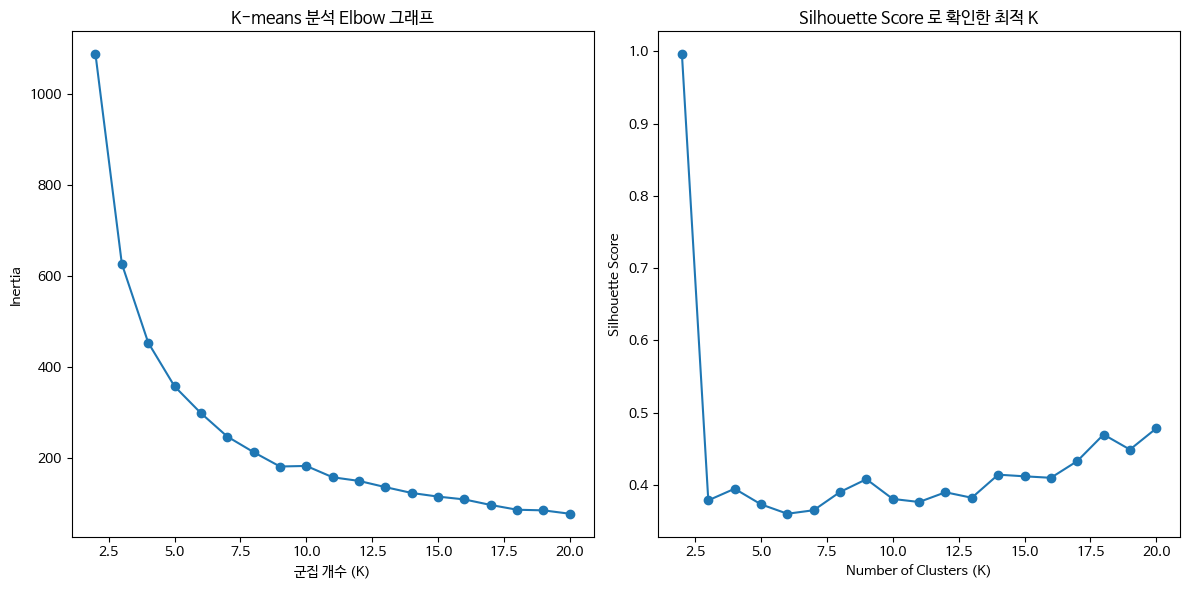

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_num_tmp_km)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_num_tmp_km, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

#### 최적 K로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=12, random_state=22)
kmeans.fit(df_num_tmp_km)

# 클러스터 결과를 데이터프레임에 추가
df_num_tmp_km['cluster_num'] = kmeans.labels_

#### 군집 분포 확인

In [ ]:
df_num_tmp_km['상품명'] = df_tmp['상품명']
df_num_tmp_km['은행명'] = df_tmp['금융회사']

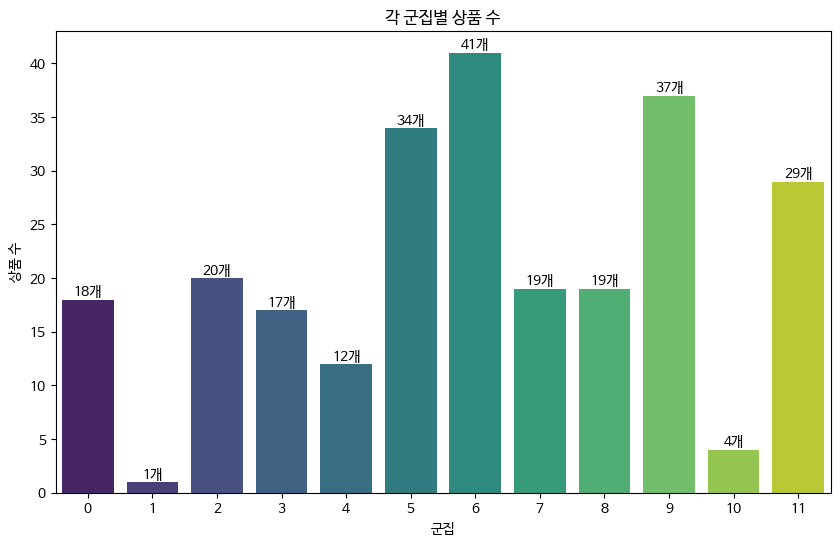

In [ ]:
df_result_km = df_num_tmp_km.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

# [6] 텍스트 군집분석 실시

## 5.1 전처리

In [ ]:
df_tmp.columns

Index(['금융회사', '상품명', '적립방식', '세전이자율', '세후이자율', '최고우대금리', '이자계산방식', '우대조건',
       '가입방법', '만기후 이자율', '기타유의사항', '가입대상_최종', '가입대상_존재여부', '나이제한',
       '나이제한_존재여부', '우대조건_존재여부', '가입방식우대_존재여부', '이체우대_존재여부', '만기우대_존재여부',
       '실적우대_존재여부', '기타우대_존재여부', '실질이자율', '최고_기본_diff', '최고기본금리차이',
       '최고_기준_diff', '최고기준금리차이', '금융회사_종류', '구분', '등급'],
      dtype='object')

In [ ]:
df_num_tmp = df_tmp[['가입대상_존재여부','나이제한_존재여부','우대조건_존재여부', '가입방식우대_존재여부',
                     '이체우대_존재여부', '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부']]

- 라벨 인코딩

In [ ]:
label_cols = ['가입대상_존재여부','나이제한_존재여부','우대조건_존재여부', '가입방식우대_존재여부',
                     '이체우대_존재여부', '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부']
label_mapping = {}

label_encoder = LabelEncoder()
for col in label_cols:
    df_num_tmp[col] = label_encoder.fit_transform(df_num_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [ ]:
# 변환된 값 확인
print("Label Encoding Mapping:")
for col, mapping in label_mapping.items():
    print(f"{col} 변환 전: 후 -> {mapping}")

Label Encoding Mapping:
가입대상_존재여부 변환 전: 후 -> {0: 0, 1: 1}
나이제한_존재여부 변환 전: 후 -> {0: 0, 1: 1}
우대조건_존재여부 변환 전: 후 -> {0: 0, 1: 1}
가입방식우대_존재여부 변환 전: 후 -> {'대면': 0, '비대면': 1, '우대없음': 2}
이체우대_존재여부 변환 전: 후 -> {'급여이체우대': 0, '우대없음': 1, '자동이체우대': 2, None: 3}
만기우대_존재여부 변환 전: 후 -> {'만기시우대': 0, '우대없음': 1}
실적우대_존재여부 변환 전: 후 -> {'우대없음': 0, '카드 외 실적우대': 1, '카드실적우대': 2}
기타우대_존재여부 변환 전: 후 -> {'마켓팅동의우대': 0, '마켓팅동의우대 최초고객우대': 1, '마켓팅동의우대 해당은행우대': 2, '우대없음': 3, '직장인우대': 4, '청약가입우대': 5, '청약가입우대 최초고객우대 해당은행우대': 6, '청약가입우대 해당은행우대': 7, '최초고객우대': 8, '최초고객우대 해당은행우대': 9, '해당은행우대': 10}


In [ ]:
df_num_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   가입대상_존재여부    251 non-null    int64
 1   나이제한_존재여부    251 non-null    int64
 2   우대조건_존재여부    251 non-null    int64
 3   가입방식우대_존재여부  251 non-null    int64
 4   이체우대_존재여부    251 non-null    int64
 5   만기우대_존재여부    251 non-null    int64
 6   실적우대_존재여부    251 non-null    int64
 7   기타우대_존재여부    251 non-null    int64
dtypes: int64(8)
memory usage: 17.6 KB


## 5.2 군집분석 (K-means)

#### 데이터 확인

In [ ]:
df_num_tmp_km = df_num_tmp.copy()

In [ ]:
df_num_tmp_km

,가입대상_존재여부,나이제한_존재여부,우대조건_존재여부,가입방식우대_존재여부,이체우대_존재여부,만기우대_존재여부,실적우대_존재여부,기타우대_존재여부
0,1,0,1,0,1,1,0,6
1,1,0,0,2,1,1,0,3
2,1,0,0,2,1,1,0,3
3,0,0,0,2,1,1,0,3
4,0,0,0,2,1,1,0,3
...,...,...,...,...,...,...,...,...
246,1,0,0,2,1,1,0,3
247,0,0,0,2,1,1,0,3
248,0,0,0,2,1,1,0,3
249,0,0,0,2,1,1,0,3


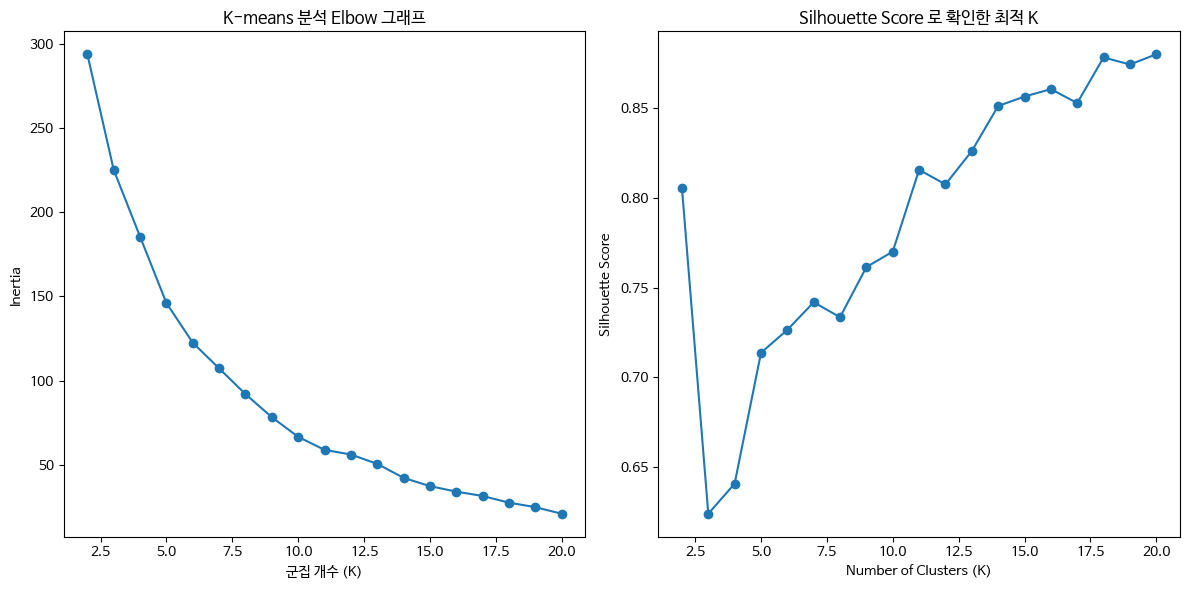

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_num_tmp_km)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_num_tmp_km, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

#### 최적 K로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=11, random_state=22)
kmeans.fit(df_num_tmp_km)

# 클러스터 결과를 데이터프레임에 추가
df_num_tmp_km['cluster_num'] = kmeans.labels_

#### 군집 분포 확인

In [ ]:
df_num_tmp_km['상품명'] = df_tmp['상품명']
df_num_tmp_km['은행명'] = df_tmp['금융회사']

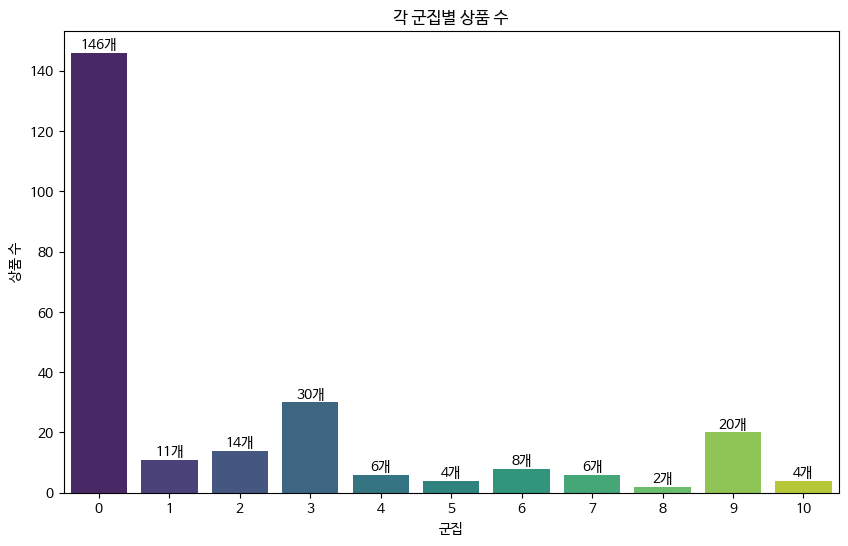

In [ ]:
df_result_km = df_num_tmp_km.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

## 5.3 군집별 특징 파악

### 시각화 전처리

In [ ]:
df_num_tmp_km.columns

Index(['가입대상_존재여부', '나이제한_존재여부', '우대조건_존재여부', '가입방식우대_존재여부', '이체우대_존재여부',
       '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부', 'cluster_num', '상품명', '은행명'],
      dtype='object')

In [ ]:
df_num_mean_result = df_num_tmp_km.groupby(['cluster_num']).mean()[['가입대상_존재여부', '나이제한_존재여부', '우대조건_존재여부', '가입방식우대_존재여부', '이체우대_존재여부',
       '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부']].reset_index()

### 전체적인 평균 분포 확인

In [ ]:
df_num_mean_result

,cluster_num,가입대상_존재여부,나이제한_존재여부,우대조건_존재여부,가입방식우대_존재여부,이체우대_존재여부,만기우대_존재여부,실적우대_존재여부,기타우대_존재여부
0,0,0.000000,0.000000,0.0,2.000000,1.000000,1.000000,0.000000,3.000000
1,1,0.090909,0.000000,1.0,1.727273,1.090909,0.363636,0.000000,7.909091
2,2,0.928571,0.357143,1.0,2.000000,1.285714,0.428571,0.000000,3.000000
3,3,0.066667,0.000000,1.0,1.066667,1.000000,0.966667,0.000000,3.000000
4,4,0.500000,0.166667,1.0,1.833333,1.666667,1.000000,1.666667,3.666667
5,5,1.000000,0.250000,1.0,1.750000,0.750000,1.000000,1.250000,0.000000
6,6,1.000000,1.000000,0.0,2.000000,1.000000,1.000000,0.000000,3.000000
7,7,0.500000,0.000000,1.0,2.000000,1.833333,0.500000,0.333333,9.666667
8,8,1.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,6.000000
9,9,1.000000,0.000000,0.0,2.000000,1.000000,1.000000,0.000000,3.000000


- 군집별 평균을 비교하는 Barplot 함수 생성

In [ ]:
def plot_cluster_comparison(df, feature):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='cluster_num', y=feature, data=df, palette='Paired')

    for p in ax.patches:
         ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.title(f'군집별 평균 {feature} 비교')

    plt.xlabel('군집')
    plt.ylabel(feature)

    plt.show()

In [ ]:
df_num_mean_result.columns

Index(['cluster_num', '가입대상_존재여부', '나이제한_존재여부', '우대조건_존재여부', '가입방식우대_존재여부',
       '이체우대_존재여부', '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부'],
      dtype='object')

### 각 컬럼 분포 확인

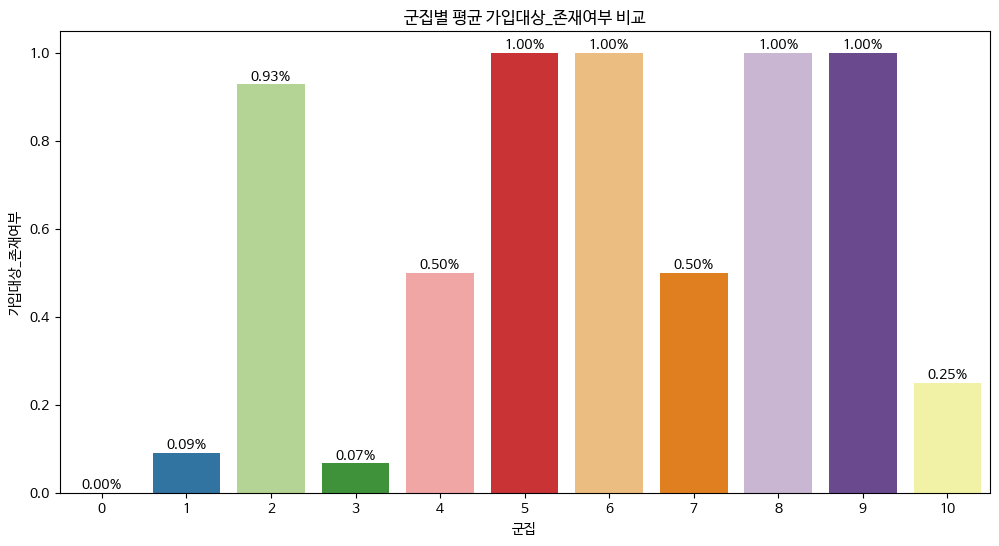

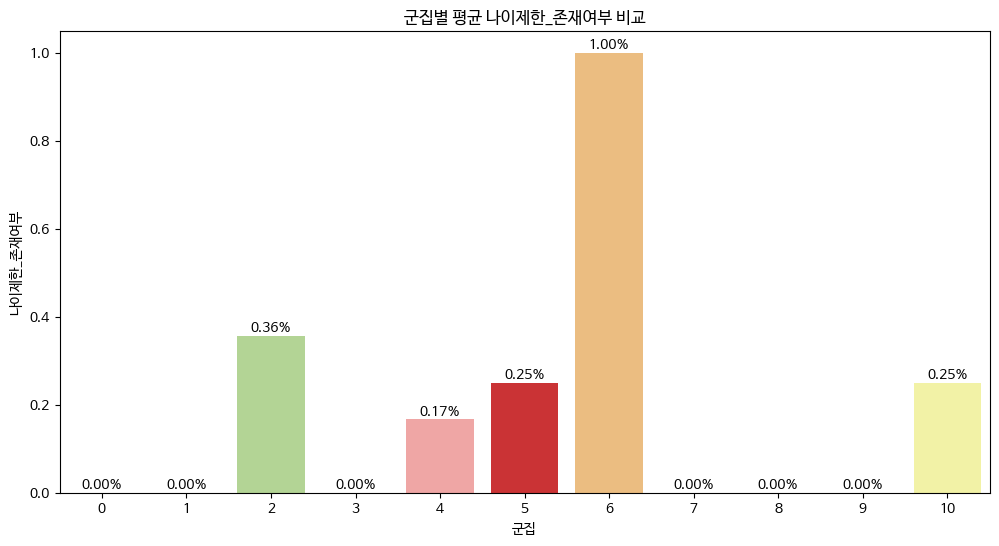

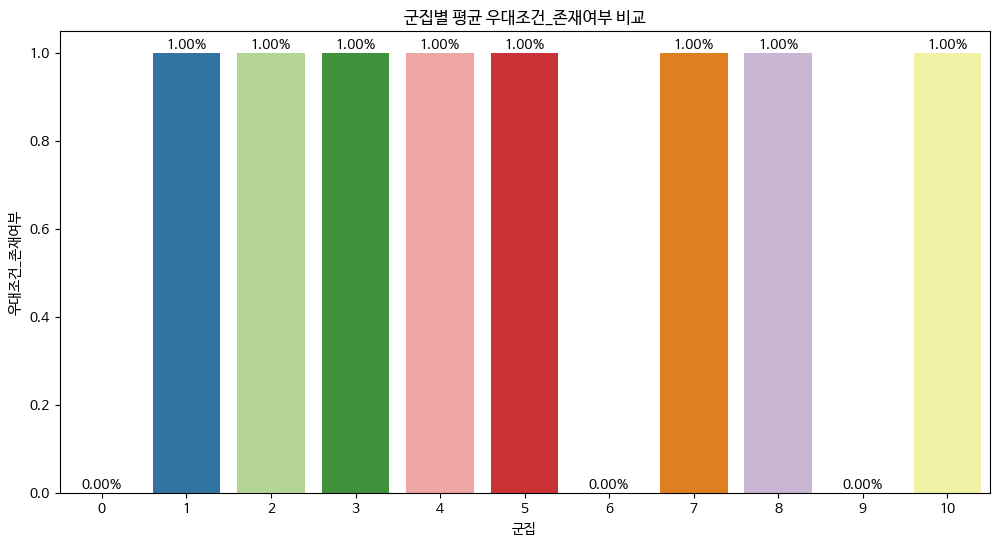

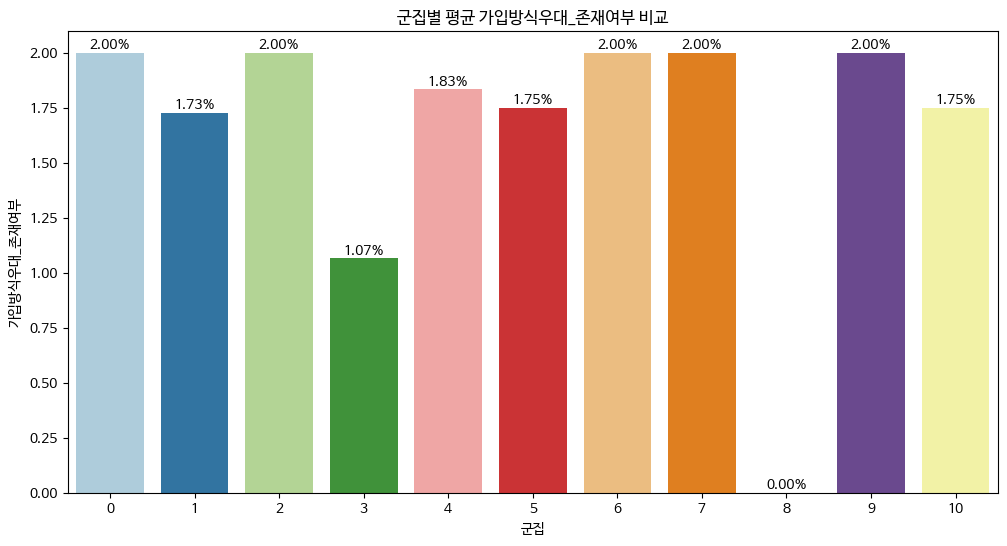

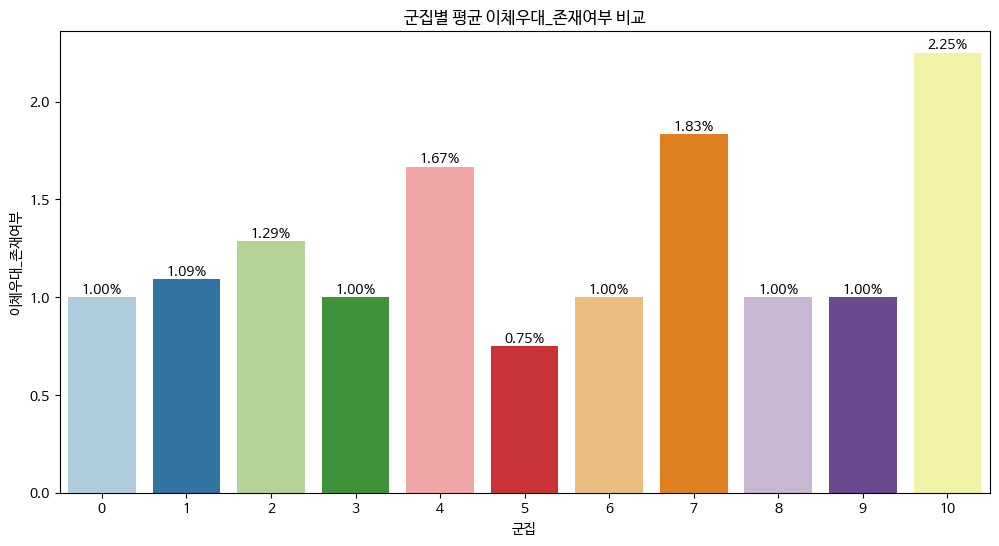

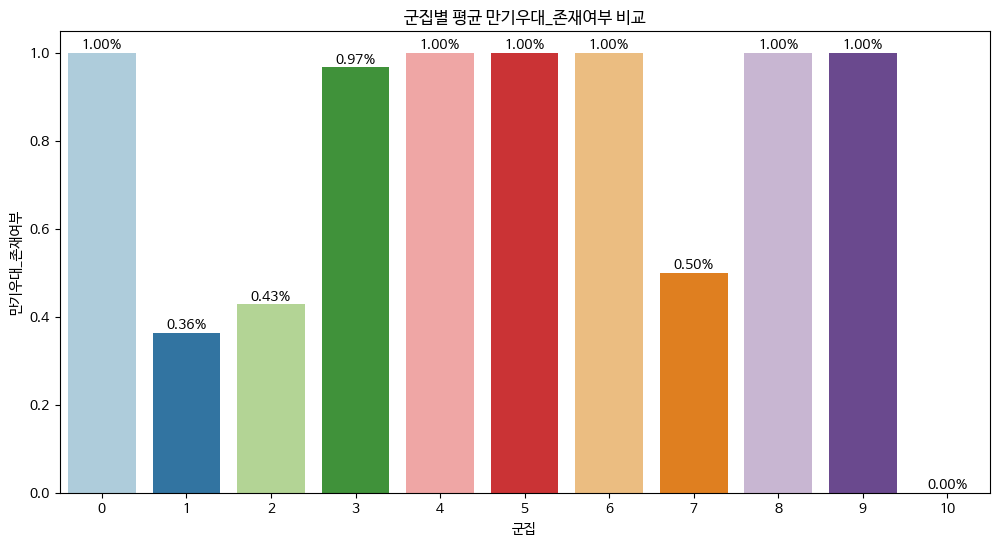

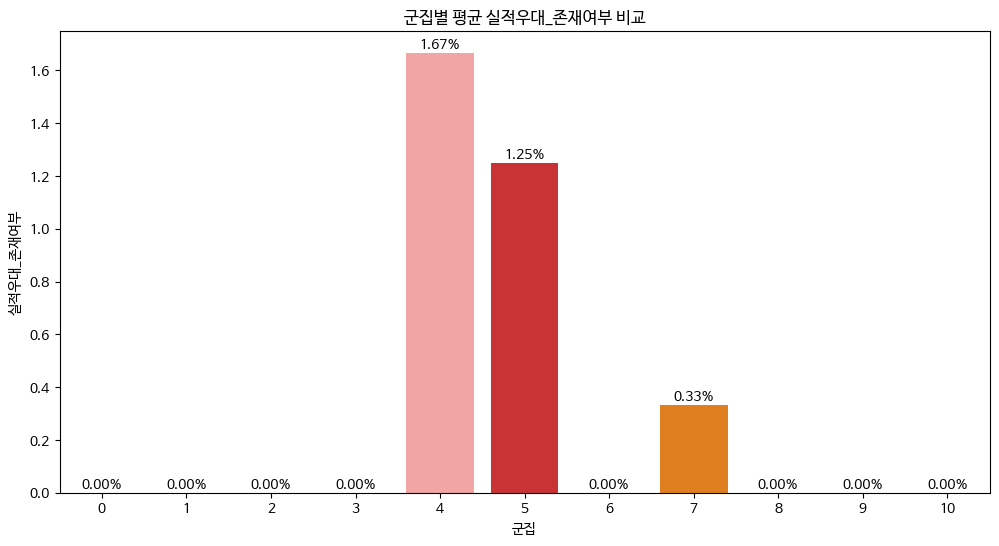

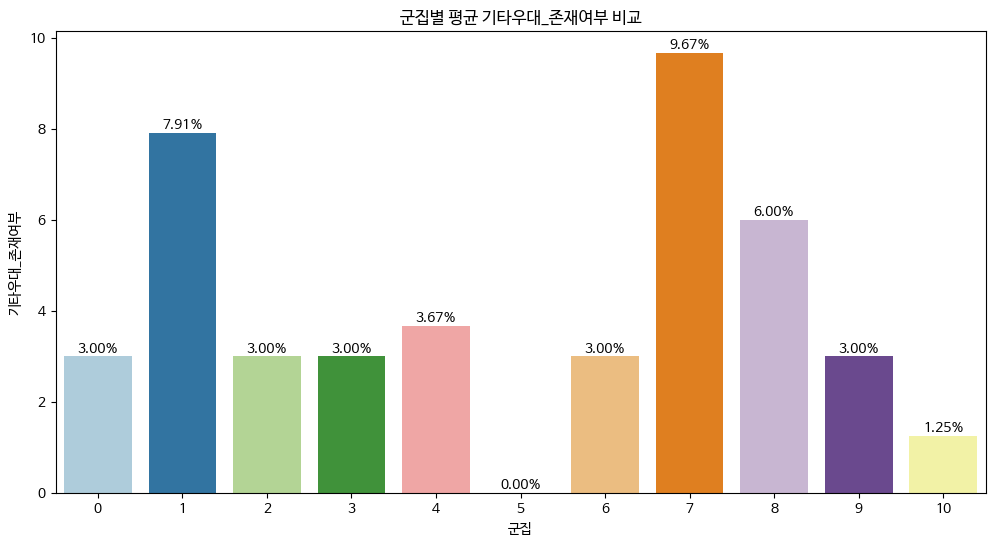

In [ ]:
for c in df_num_mean_result.columns[1:]:
    plot_cluster_comparison(df_num_mean_result, c)

### Tabulate 보여주기

In [ ]:
from tabulate import tabulate

def cutthe_text(strs):
    if isinstance(strs, str) and len(strs) > 30:
        return strs[:30]
    elif pd.isna(strs):
        return 'NaN'
    else:
        return strs

def decode_txt(strs):
    try:
        return strs.decode('utf-8')
    except:
        return strs

# for c, m in label_mapping.items():
#     dict_swap = {v:k for k,v in m.items()}
#     df_num_tmp_km[c] = df_num_tmp_km[c].apply(lambda x : dict_swap[x] )
#     dict_swap = {v:k for k,v in m.items()}
    # # print(dict_swap)
    # print(tmp[c].apply(lambda x : dict_swap[x] ))

for i in range(11):
    print("cluster {}".format(i), '\n', tabulate(df_num_tmp_km[df_num_tmp_km.cluster_num == i].applymap(decode_txt)[['상품명', '은행명', '가입대상_존재여부', '나이제한_존재여부', '우대조건_존재여부', '가입방식우대_존재여부', '이체우대_존재여부',
       '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부']].applymap(cutthe_text).head(30),
                                                  headers='keys', tablefmt='psql'))

cluster 0 
 +----+---------------------------------+------------------+---------------------+---------------------+---------------------+-------------------------+---------------------+---------------------+---------------------+---------------------+
|    | 상품명                          | 은행명           |   가입대상_존재여부 |   나이제한_존재여부 |   우대조건_존재여부 | 가입방식우대_존재여부   | 이체우대_존재여부   | 만기우대_존재여부   | 실적우대_존재여부   | 기타우대_존재여부   |
|----+---------------------------------+------------------+---------------------+---------------------+---------------------+-------------------------+---------------------+---------------------+---------------------+---------------------|
|  3 | 비대면 정기적금                 | 한국투자저축은행 |                   0 |                   0 |                   0 | 우대없음                | 우대없음            | 우대없음            | 우대없음            | 우대없음            |
|  4 | 스마트뱅킹 정기적금             | 한국투자저축은행 |                   0 |                   0 |                   0 | 우대없음                | 우대없음

# [7] 수치형 + 텍스트 군집분석 실시


## 7.1 전처리

In [ ]:
df_tmp.columns
df_num_tmp = df_tmp[['가입대상_존재여부','나이제한_존재여부','우대조건_존재여부', '가입방식우대_존재여부',
                     '이체우대_존재여부', '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부']